# Getting Started

In [48]:
# target value normalization needed:done

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [2]:
image_dir = Path('H:\project(calorific value)\cnn\images_3')

# Create File DataFrame

In [3]:
gcv = pd.read_csv('target.csv', squeeze=True) # squeeze in used to convert the dataframe to series
#gcv = gcv.values
gcv

<ipython-input-3-84b12b9b79af>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  gcv = pd.read_csv('target.csv', squeeze=True) # squeeze in used to convert the dataframe to series


0       12312
1       11290
2       12674
3       10130
4       12559
        ...  
6577    11511
6578    11862
6579    10370
6580    10951
6581    11226
Name: gcv, Length: 6582, dtype: int64

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
gcv_scaled = scaler.fit_transform(gcv.values.reshape(-1,1))

In [5]:
gcv_scaled

array([[0.76401061],
       [0.68183646],
       [0.79311731],
       ...,
       [0.60786363],
       [0.65457908],
       [0.67669052]])

In [6]:
gcv_scaled = gcv_scaled.reshape(1,-1)
gcv_scaled = gcv_scaled.squeeze()
gcv_scaled = pd.Series(gcv_scaled, name='gcv')
gcv_scaled


0       0.764011
1       0.681836
2       0.793117
3       0.588566
4       0.783871
          ...   
6577    0.699606
6578    0.727828
6579    0.607864
6580    0.654579
6581    0.676691
Name: gcv, Length: 6582, dtype: float64

In [7]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)

images = pd.concat([filepaths, gcv], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [8]:
images.head()

,Filepath,gcv
0,H:\project(calorific value)\cnn\images_3\3099.jpg,11914
1,H:\project(calorific value)\cnn\images_3\6181.jpg,13591
2,H:\project(calorific value)\cnn\images_3\2210.jpg,14766
3,H:\project(calorific value)\cnn\images_3\2693.jpg,12954
4,H:\project(calorific value)\cnn\images_3\2194.jpg,9909


In [9]:
# Let's only use 5000 images to speed up training time
image_df = images.sample(5000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

In [10]:
image_df

,Filepath,gcv
0,H:\project(calorific value)\cnn\images_3\3625.jpg,6664
1,H:\project(calorific value)\cnn\images_3\2591.jpg,11070
2,H:\project(calorific value)\cnn\images_3\1922.jpg,7330
3,H:\project(calorific value)\cnn\images_3\2215.jpg,11722
4,H:\project(calorific value)\cnn\images_3\610.jpg,14187
...,...,...
4995,H:\project(calorific value)\cnn\images_3\733.jpg,8474
4996,H:\project(calorific value)\cnn\images_3\1062.jpg,12545
4997,H:\project(calorific value)\cnn\images_3\1713.jpg,13734
4998,H:\project(calorific value)\cnn\images_3\5068.jpg,11741


# Loading Images

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='gcv',
    color_mode='grayscale',
    target_size=(640, 180),
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='gcv',
    color_mode='grayscale',
    target_size=(640, 180),
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='gcv',
    color_mode='grayscale',
    target_size=(640, 180),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 3000 validated image filenames.
Found 750 validated image filenames.
Found 1250 validated image filenames.


In [13]:
test_images.labels

array([10262, 12474, 13200, ...,  9399, 14089, 10218], dtype=int64)

In [14]:

# function to convert seconds to into hours, minutes and seconds
# this function is used to measure the running time of any model
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

# Training

In [16]:
inputs = tf.keras.Input(shape=(640, 180, 1))
x = tf.keras.layers.Conv2D(filters=32, strides=2, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D()(x)
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
#x = tf.keras.layers.Dense(0, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='Adam',
    loss='mse'
)

import time
start = time.time() # starting of the time

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

end = time.time() # ending of the time
print('run_time:', convert(end - start), 'h:m:s')


Epoch 1/10
94/94 [==============================] - 174s 2s/step - loss: 9868666.0000 - val_loss: 5423141.0000
Epoch 2/10
94/94 [==============================] - 95s 1s/step - loss: 5509381.5000 - val_loss: 5194424.0000
Epoch 3/10
94/94 [==============================] - 93s 984ms/step - loss: 5464595.0000 - val_loss: 5014553.5000
Epoch 4/10
94/94 [==============================] - 74s 788ms/step - loss: 5067518.5000 - val_loss: 4897231.0000
Epoch 5/10
94/94 [==============================] - 75s 802ms/step - loss: 5302549.0000 - val_loss: 5718640.5000
Epoch 6/10
94/94 [==============================] - 72s 770ms/step - loss: 4955453.0000 - val_loss: 4857394.0000
Epoch 7/10
94/94 [==============================] - 80s 844ms/step - loss: 4976991.0000 - val_loss: 4929308.0000
Epoch 8/10
94/94 [==============================] - 74s 790ms/step - loss: 5183465.0000 - val_loss: 5732549.5000
Epoch 9/10
94/94 [==============================] - 79s 834ms/step - loss: 4731832.5000 - val_loss: 5

In [86]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 640, 180, 1)]     0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 320, 90, 32)       320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 160, 45, 32)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 80, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 40, 11, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 28160)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                140

# Results

In [87]:
pred = np.squeeze(model.predict(test_images))
y_test = test_images.labels

mse = model.evaluate(test_images, verbose=0)
print("     Test MSE: {:.5f}".format(mse))

r2 = r2_score(y_test, pred)
print("Test R^2 Score: {:.5f}".format(r2))

     Test MSE: 4805096.00000
Test R^2 Score: 0.12129


In [60]:
# model.save('cnn_model.h5')
# model = keras.models.load_model('cnn_model.h5')

Null/Baseline Model Test RMSE: 2328.52984


In [78]:
pred

array([10710.199, 11257.08 , 11260.402, ..., 11994.584, 10170.097,
       11882.53 ], dtype=float32)

In [79]:
y_test

array([10262, 12474, 13200, ...,  9399, 14089, 10218], dtype=int64)

In [88]:

# explained_variance
from sklearn.metrics import explained_variance_score
explained_variance = explained_variance_score(y_test, pred)

# r2_score
from sklearn.metrics import r2_score
r2 = r2_score(y_test,pred)

# max_error
from sklearn.metrics import max_error
max_error = max_error(y_test, pred)

# min error
min_error = min(abs(y_test - pred))

# mean absolute error
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test, pred)

# mean squared error
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, pred)

# mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, pred)


metrics = {
		'Performance_metrics': ['R2', 'MSE', 'Explained Variance',  'Max error', 'Min error', 'MAE',  'MAPE'],
		'parikh_et_al': [r2, MSE, explained_variance,  max_error, min_error, MAE, MAPE]
	}

performance_metrics = pd.DataFrame(metrics)
performance = performance_metrics.transpose()

print(performance)

                            0               1                   2  \
Performance_metrics        R2             MSE  Explained Variance   
parikh_et_al         0.121289  4805096.286342            0.121507   

                               3          4            5         6  
Performance_metrics    Max error  Min error          MAE      MAPE  
parikh_et_al         7564.920898   1.564453  1718.069591  0.180299  


In [89]:
performance.to_csv('performance_metrics_for_cnn.csv')

Text(0.5, 1.0, 'Regression Plot')

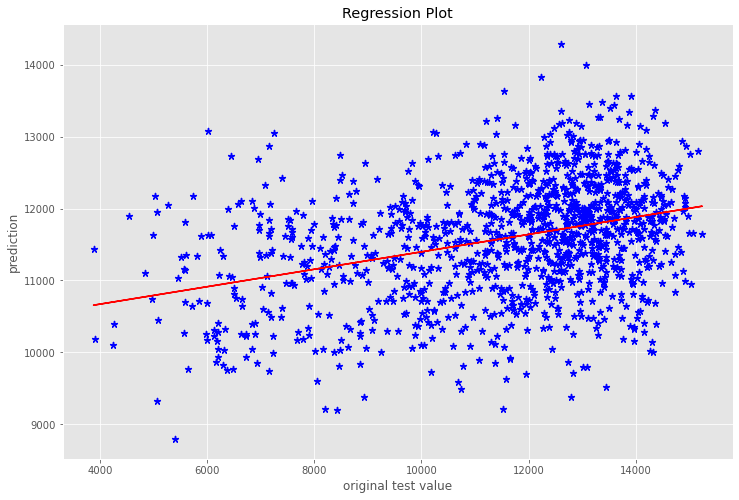

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
x, y = y_test, pred
plt.scatter(x, y, color='blue', marker=(5,2))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='r')
plt.xlabel("original test value")
plt.ylabel("prediction")
plt.title("Regression Plot")